### **Overview:**

This analysis was part of my submission for the Great Learning Spring 2023 Hack Linguist Hackathon Competition. The dataset used in the analysis were provided by Great Learning. The general framework for the hackathon was that competitors were provided a brief outline, goal, and evalutation criteria. Competitors chose the Machine Learning approach to take and tools to use.

This problem was based on the Shinkansen Bullet Train dataset. The dataset contains a random sample of individuals who traveled on the bullet train train. Passengers were asked to provide their feedback on various parameters related to the travel, on-time performance of the trains, passenger information, along with their overall experience is also recorded. In the survey, each passenger was explicitly asked whether they were satisfied with their overall travel experience or not, and that is captured in the data of the survey report under the variable labeled ‘Overall_Experience’. The objective of the problem is to understand which parameters play an important role in swaying passenger feedback towards a positive scale and accurately predict whether a passenger had a good experience. 

This is a classification problem involving many features, both categorical and numeric. I chose to take a classic machine learning classification approach and use three different models:
- random forest 
- XGBoost
- XGBoost (Regression)

**Goal:**

The goal of the problem was to predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train.

**Dataset:**

The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they traveled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.

The data has been split into two groups and provided in the Dataset folder. The folder contains both train and test data separately.

Train_Data
Test_Data

**Target Variable:** 

- Overall_Experience (1 represents ‘satisfied’, and 0 represents ‘not satisfied’)

**Evaluation metric:**

- Accuracy Score: The evaluation metric is simply the percentage of predictions made by the model that turned out to be correct. This is also called the accuracy of the model. It will be calculated as the total number of correct predictions (True Positives + True Negatives) divided by the total number of observations in the dataset (In other words, the best possible accuracy is 100% (or 1) and the worst possible accuracy 0%). 

### **Importing Libraries and the Dataset**

In [100]:
import warnings
warnings.filterwarnings("ignore")

# Libraries for data manipulation and visualization
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# To tune model, get different metric scores, and split data
# To tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# label encoder 
from sklearn import preprocessing


# To impute missing values
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Importing the XGBClassifier from the xgboost library
from xgboost import XGBClassifier
import xgboost as xgb

# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Loading the  datasets

In [21]:
survey_train = pd.read_csv("Surveydata_train_(2).csv")
survey_test = pd.read_csv("Surveydata_test_(2).csv")
travel_train = pd.read_csv("Traveldata_train_(2).csv")
travel_test = pd.read_csv("Traveldata_test_(2).csv")

First I merge independent survey and travel datasets into single train and test datasets. Because the data has been provided pre split into train and test, I dont need to separate it myself, if I were we would need to take care of that before conducting EDA.

In [24]:
train = pd.merge(travel_train,survey_train, on='ID', how='inner')
test = pd.merge(travel_test,survey_test, on='ID', how='inner')

lets get a better understand of the data by taking a look at a summary of the train dataframe...

### Exploratory Data Analysis

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_Comfort             94318 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  85449 non-null  object 
 13  Catering                 85638 non-null  object 
 14  Platform_Location     

In [8]:
train.ID.nunique()

94379

Some observations from this overview are that there are 94379 unique rows in the dataframe, and there are no duplicate rows un the 'ID' field.
There is a mixture of numeric and catagorical data in the dataset. There are 25 total features, but we can drop 'ID' as it does not provide any additional information for this analysis (it is an index/key).
The field 'Overall_Experience' is the y variable, this is what I will be making predictions on. Also we can see that there are missing values in many of the fields (both catagorical and numeric). How you deal with missing values can play an important role in how accurate the ML models will be able to predict Overall_Experience. I still want to get a better understanding of each of the features in the data set and how they are distributed. Next I am going to print out a basic summary of the numeric features:

In [9]:
# Selecting numerical columns and checking the summary statistics
num_cols = train.select_dtypes('number').columns

train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Age,94346.0,3.941965e+01,15.116632,7.0,27.0,40.0,51.0,85.0
Travel_Distance,94379.0,1.978888e+03,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,1.464709e+01,38.138781,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,1.500522e+01,38.439409,0.0,0.0,0.0,13.0,1584.0
Overall_Experience,94379.0,5.466576e-01,0.497821,0.0,0.0,1.0,1.0,1.0


ID is not important, I will drop that. The median age of survey participants riding the bullet train is 40, and age looks almsot normally distributed. There is large range in the travel distance records. Departure and Arrival delays also look like they may be skewed. Lets plot these to get a better idea:

ID
Skew : 0.0


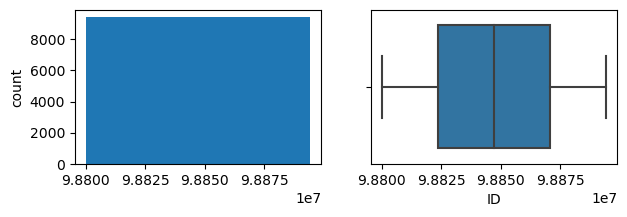

Age
Skew : -0.0


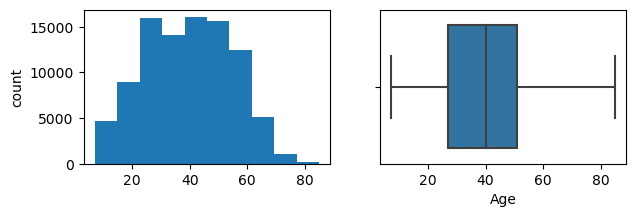

Travel_Distance
Skew : 0.47


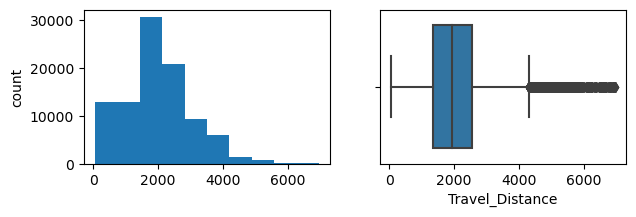

Departure_Delay_in_Mins
Skew : 7.16


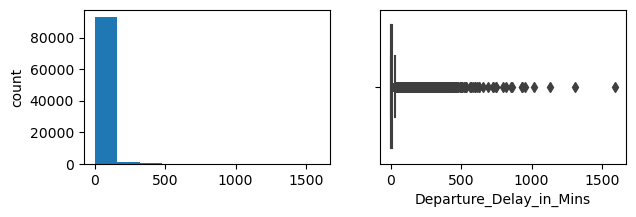

Arrival_Delay_in_Mins
Skew : 6.98


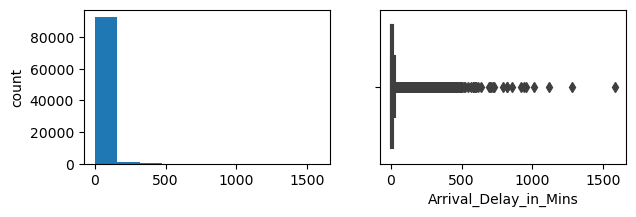

Overall_Experience
Skew : -0.19


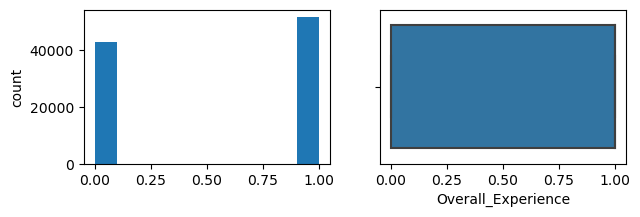

In [98]:
for col in num_cols:
    print(col)
    
    print('Skew :', round(train[col].skew(), 2))
    
    plt.figure(figsize = (7, 2))
    
    plt.subplot(1,2,1)
    
    train[col].hist(bins = 10, grid = False)
    
    plt.ylabel('count')
    
    plt.subplot(1, 2, 2)
    
    sns.boxplot(x = train[col])
    
    plt.show()

It looks like Age is actually more or less normally distributed. The more normal the features are, the better the classification models will perform (and the less I will need to transform). Travel Distance is somewhat right skewed, and as I suspected departure and arrival delays are highly right skewed. These will need to be dealt will. There are several different approaches one could take to normalize data like this in classification problems. The approach I take later in this analysis is to use feature engineering to bin the values into categories. 
Lets also take a look at the balance between negative and postiive overall experience:

In [11]:
train.Overall_Experience.value_counts(normalize = True)

1    0.546658
0    0.453342
Name: Overall_Experience, dtype: float64

There are marginally more positives than negatives, we can take balance into account when tuning the classifer models. Next, lets take a closer look at the categorical features:

In [12]:
cat_cols = ['Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class',
       'Seat_Comfort', 'Seat_Class',
       'Arrival_Time_Convenient', 'Catering', 'Platform_Location',
       'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
       'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
       'Baggage_Handling', 'CheckIn_Service', 'Cleanliness',
       'Online_Boarding']

for col in cat_cols:    
    print(train[col].value_counts(normalize = True))  # The parameter normalize = True gives the percentage of each category
    print('*'*40)                                    # Print the * 40 times to separate different variables

Female    0.507041
Male      0.492959
Name: Gender, dtype: float64
****************************************
Loyal Customer       0.817332
Disloyal Customer    0.182668
Name: Customer_Type, dtype: float64
****************************************
Business Travel    0.688373
Personal Travel    0.311627
Name: Type_Travel, dtype: float64
****************************************
Eco         0.522807
Business    0.477193
Name: Travel_Class, dtype: float64
****************************************
Acceptable           0.224326
Needs Improvement    0.222079
Good                 0.218357
Poor                 0.160998
Excellent            0.137524
Extremely Poor       0.036716
Name: Seat_Comfort, dtype: float64
****************************************
Green Car    0.502601
Ordinary     0.497399
Name: Seat_Class, dtype: float64
****************************************
Good                 0.229072
Excellent            0.206954
Acceptable           0.177615
Needs Improvement    0.175426
Poor        

most of the categorical features are ordinal. This is important to note as we will need to encode them in preprocessing before running the models. There are no missing categories but there is imbalance in the percentage of data in each catagory (some categories are not very well represented). 
Finally, lets see if any of the features in the data are correlated:

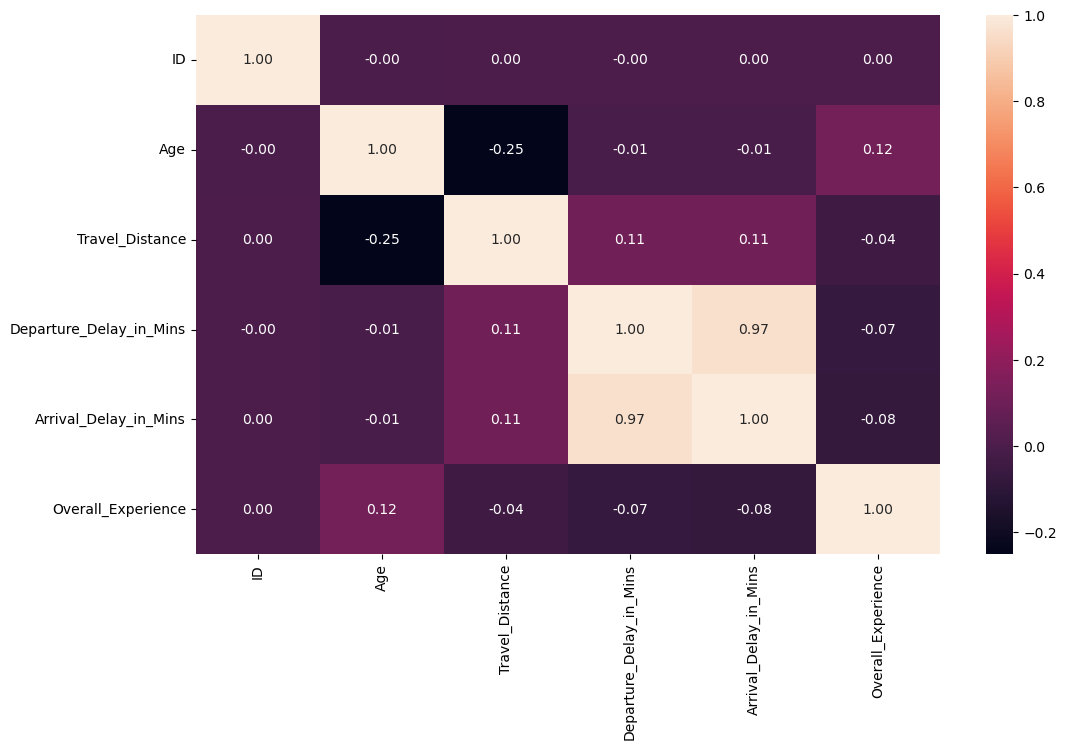

In [14]:
plt.figure(figsize = (12, 7))

sns.heatmap(train.corr(), annot = True, fmt = ".2f")

plt.show()

Arrival and Departure delay are highly correlated (suprise suprise :), but there is little correlation between any of the other numeric variables. 

### Preprocessing the training data

This is where Im going to drop the ID column out, and then split the data into the x (features) and y (target variable)

In [25]:
# Separating the target variable and other variables
x_train2 = train.drop(columns = 'Overall_Experience')
x_train2 = x_train2.drop(["ID"], axis = 1)
y_train2 = train['Overall_Experience']

Im going to impute the numeric features using an iterative imputer to replace missing values based on all other features for a record, and categorical features will be replaced with the most frequent value for each column. After imputing, in the same code chunk, I encode the categorical features. Since most of the categorical features are oridinal, and there are many levels, I use the label_encoder method rather than one-hot encoding. With decision trees and random forest, one hot encoding can increase the number of features so much that it introduces 'noise' and leads to multicoliniarity. 

In [102]:
# create list of categorical and numeric features with missing data that needs to be imputed
impute_catcols = ['Gender','Customer_Type','Age','Type_Travel','Seat_Comfort','Arrival_Time_Convenient','Catering','Platform_Location','Onboard_Wifi_Service','Onboard_Entertainment',
                  'Online_Support','Ease_of_Online_Booking','Onboard_Service','Legroom','Baggage_Handling','CheckIn_Service','Cleanliness','Online_Boarding']
impute_numcols = ['Departure_Delay_in_Mins','Arrival_Delay_in_Mins']

In [103]:
# instantiate the imputers
imputerA = IterativeImputer(random_state=0)
imputerB = SimpleImputer(strategy="most_frequent")

In [28]:
# impute the numeric columns, then Fit and transform the train data using the standard scalar
x_train2[impute_numcols] = pd.DataFrame(imputerA.fit_transform(x_train2[impute_numcols]), columns=x_train2[impute_numcols].columns)
scaler = StandardScaler()
x_train2[impute_numcols] = scaler.fit_transform(x_train2[impute_numcols])

#impute the categorical colums
x_train2[impute_catcols] = pd.DataFrame(imputerB.fit_transform(x_train2[impute_catcols]), columns=x_train2[impute_catcols].columns)
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in catagorocal columns
for x in cat_cols:
    x_train2[x] = label_encoder.fit_transform(x_train2[x])

Next, I bin the arrival and departure delay features to decrease the effect of skew and outliers

In [29]:
x_train2.loc[x_train2['Departure_Delay_in_Mins']<1,'Departure_Delay_in_Mins'] = 0
x_train2.loc[(x_train2['Departure_Delay_in_Mins']>=1)&(x_train2['Departure_Delay_in_Mins']<5),'Departure_Delay_in_Mins'] = 1
x_train2.loc[(x_train2['Departure_Delay_in_Mins']>=5)&(x_train2['Departure_Delay_in_Mins']<30),'Departure_Delay_in_Mins'] = 2
x_train2.loc[(x_train2['Departure_Delay_in_Mins']>=30)&(x_train2['Departure_Delay_in_Mins']<60),'Departure_Delay_in_Mins'] = 3
x_train2.loc[(x_train2['Departure_Delay_in_Mins']>60),'Departure_Delay_in_Mins'] = 4

x_train2.loc[x_train2['Arrival_Delay_in_Mins']<1,'Arrival_Delay_in_Mins'] = 0
x_train2.loc[(x_train2['Arrival_Delay_in_Mins']>=1)&(x_train2['Arrival_Delay_in_Mins']<5),'Arrival_Delay_in_Mins'] = 1
x_train2.loc[(x_train2['Arrival_Delay_in_Mins']>=5)&(x_train2['Arrival_Delay_in_Mins']<30),'Arrival_Delay_in_Mins'] = 2
x_train2.loc[(x_train2['Arrival_Delay_in_Mins']>=30)&(x_train2['Arrival_Delay_in_Mins']<60),'Arrival_Delay_in_Mins'] = 3
x_train2.loc[(x_train2['Arrival_Delay_in_Mins']>60),'Arrival_Delay_in_Mins'] = 4

and make sure all of the features are numeric

In [30]:
x_train2['Age'] = pd.to_numeric(x_train2['Age'])

### Random Forest

In [ ]:
# Function to print classification report and get confusion matrix in a proper format
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize = (8, 5))
    
    sns.heatmap(cm, annot = True,  fmt = '.2f', xticklabels = ['Not Canceled', 'Canceled'], yticklabels = ['Not Canceled', 'Canceled'])
    
    plt.ylabel('Actual')
    
    plt.xlabel('Predicted')
    
    plt.show()

In [179]:
# Fitting the random forest tree classifier on the training data
rf_estimator = RandomForestClassifier(random_state = 7, criterion = "gini")

rf_estimator.fit(x_train,y_train)

RandomForestClassifier(random_state=7)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42786
           1       1.00      1.00      1.00     51593

    accuracy                           1.00     94379
   macro avg       1.00      1.00      1.00     94379
weighted avg       1.00      1.00      1.00     94379



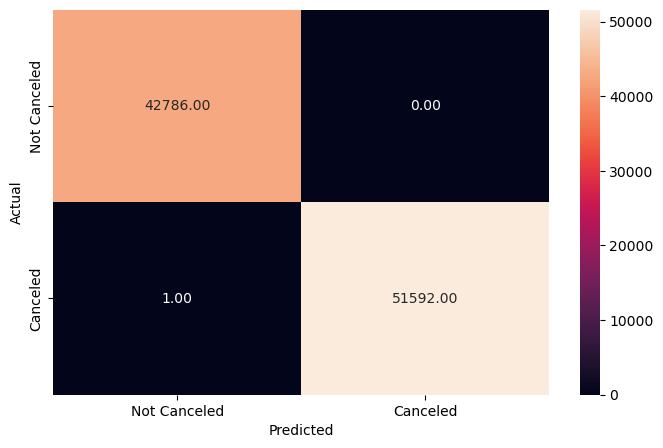

In [180]:
# Checking performance on the training data
y_pred_train3 = rf_estimator.predict(x_train)

metrics_score(y_train, y_pred_train3)

In [ ]:
# Choose the type of classifier 
rf_estimator_tuned2 = RandomForestClassifier(criterion = "gini", random_state = 7)

# Grid of parameters to choose from
parameters = {"n_estimators": [150, 250],
    "max_depth": [20,25],
    "max_features": [0.5, 0.7],
    "class_weight" : ["balanced",{0: 0.45, 1: 0.55}]
             }

# Type of scoring used to compare parameter combinations - f1 score for class 1
scorer = metrics.make_scorer(f1_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned2, parameters, scoring = scorer, cv = 5, n_jobs=-1)

grid_obj = grid_obj.fit(x_train2, y_train2)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

In [244]:
# Fitting the best algorithm to the training data
rf_estimator_tuned.fit(x_train2, y_train2)

RandomForestClassifier(class_weight={0: 0.45, 1: 0.55}, max_depth=25,
                       max_features=0.5, n_estimators=250, random_state=7)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42786
           1       1.00      1.00      1.00     51593

    accuracy                           1.00     94379
   macro avg       1.00      1.00      1.00     94379
weighted avg       1.00      1.00      1.00     94379



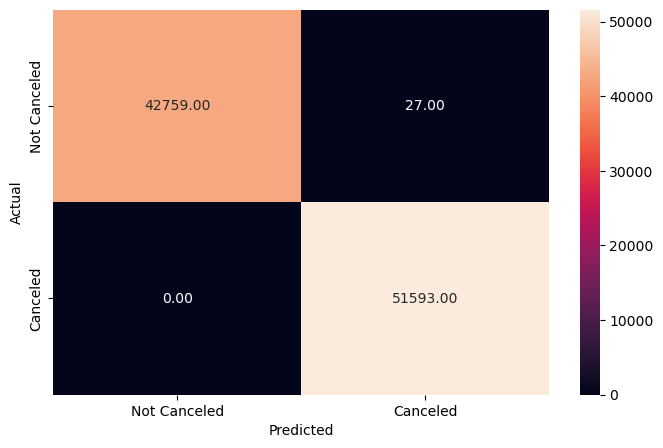

In [245]:
# Checking performance on the training data
y_pred_train = rf_estimator_tuned.predict(x_train2)

metrics_score(y_train2, y_pred_train)

In [105]:
importances = rf_estimator_tuned.feature_importances_

indices = np.argsort(importances)

feature_names = list(x_train2.columns)

plt.figure(figsize = (12, 12))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()

NameError: name 'rf_estimator_tuned2' is not defined

Now predicting y_test on x_test

In [33]:
# Separating the target variable and other variables
x_test2 = test.copy()
x_test2 = x_test2.drop(["ID"], axis = 1)
y_test2 = pd.DataFrame(test['ID'])

In [34]:
# Fit and transform the train data
x_test2[impute_numcols] = pd.DataFrame(imputerA.fit_transform(x_test2[impute_numcols]), columns=x_test2[impute_numcols].columns)
scaler = StandardScaler()
x_test2[impute_numcols] = scaler.fit_transform(x_test2[impute_numcols])

x_test2[impute_catcols] = pd.DataFrame(imputerB.fit_transform(x_test2[impute_catcols]), columns=x_test2[impute_catcols].columns)
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in catagorocal columns
for x in cat_cols:
    x_test2[x] = label_encoder.fit_transform(x_test2[x])

In [35]:
x_test2.loc[x_test2['Departure_Delay_in_Mins']<1,'Departure_Delay_in_Mins'] = 0
x_test2.loc[(x_test2['Departure_Delay_in_Mins']>=1)&(x_test2['Departure_Delay_in_Mins']<5),'Departure_Delay_in_Mins'] = 1
x_test2.loc[(x_test2['Departure_Delay_in_Mins']>=5)&(x_test2['Departure_Delay_in_Mins']<30),'Departure_Delay_in_Mins'] = 2
x_test2.loc[(x_test2['Departure_Delay_in_Mins']>=30)&(x_test2['Departure_Delay_in_Mins']<60),'Departure_Delay_in_Mins'] = 3
x_test2.loc[(x_test2['Departure_Delay_in_Mins']>60),'Departure_Delay_in_Mins'] = 4

x_test2.loc[x_test2['Arrival_Delay_in_Mins']<1,'Arrival_Delay_in_Mins'] = 0
x_test2.loc[(x_test2['Arrival_Delay_in_Mins']>=1)&(x_test2['Arrival_Delay_in_Mins']<5),'Arrival_Delay_in_Mins'] = 1
x_test2.loc[(x_test2['Arrival_Delay_in_Mins']>=5)&(x_test2['Arrival_Delay_in_Mins']<30),'Arrival_Delay_in_Mins'] = 2
x_test2.loc[(x_test2['Arrival_Delay_in_Mins']>=30)&(x_test2['Arrival_Delay_in_Mins']<60),'Arrival_Delay_in_Mins'] = 3
x_test2.loc[(x_test2['Arrival_Delay_in_Mins']>60),'Arrival_Delay_in_Mins'] = 4

In [37]:
x_test2['Age'] = pd.to_numeric(x_test2['Age'])

In [248]:
y_pred_test2 = rf_estimator_tuned2.predict(x_test2)

In [249]:
y_test2['Overall_Experience'] = y_pred_test2

### XGBoost


In [31]:
# XGBoost Classifier
xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')

# Fitting the model
xgb.fit(x_train2,y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1, ...)

Now predicting y_test on x_test

In [248]:
y_pred_test2 = rf_estimator_tuned2.predict(x_test2)

In [249]:
y_test2['Overall_Experience'] = y_pred_test2

In [40]:
y_test2.head()

,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1


this method had 0.9496 accuracy

### XGBoost Regression 

In [45]:
xgb2 = xgb.XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

xgb2.fit(x_train2,y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=0.5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [53]:
y_pred_test2 = xgb2.predict(x_test2)
y_test2['Overall_Experience'] = y_pred_test2
y_test2.loc[y_test2['Overall_Experience']<.5,'Overall_Experience'] = 0
y_test2.loc[y_test2['Overall_Experience']>.5,'Overall_Experience'] = 1
y_test2.to_csv("BenjaminCooper_HackathonSubmission_V06.csv",index=False)

In [55]:
y_test2.head()

,ID,Overall_Experience
0,99900001,1.0
1,99900002,1.0
2,99900003,1.0
3,99900004,0.0
4,99900005,1.0


<AxesSubplot: >

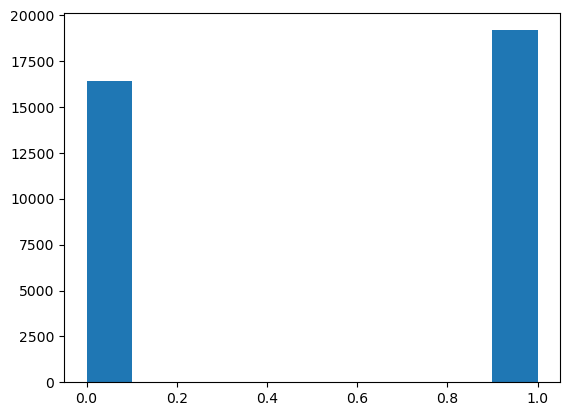

In [54]:
y_test2['Overall_Experience'].hist(bins = 10, grid = False)

### Tuning hyperparameters of XGBoost Regression


Some important hyperparameters that can be tuned:

 - **booster** [default = gbtree ] Which booster to use. Can be gbtree, gblinear, or dart; gbtree and dart use tree-based models while gblinear uses linear functions.
 
 - **min_child_weight** [default = 1]

   The minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.The larger min_child_weight is, the more conservative the algorithm will be.

  For a better understanding of each parameter in the XGBoost Classifier, please refer to this [source](https://xgboost.readthedocs.io/en/stable/parameter.html).

In [58]:
params = { 'max_depth': [3,10,20],
           'learning_rate': [0.01,0.1,0.3],
           'subsample': np.arange(0.5,1.0,0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
grid_obj = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)

In [59]:
grid_obj = grid_obj.fit(x_train2, y_train2)

# Set the classifier to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [61]:
xgb_tuned

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=1,
             colsample_bytree=0.8999999999999999, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=20, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=20, ...)

In [91]:
y_test3 = pd.DataFrame(test['ID'])
y_pred_test3 = xgb_tuned.predict(x_test2)

In [92]:
y_test3['Overall_Experience'] = y_pred_test3

<AxesSubplot: >

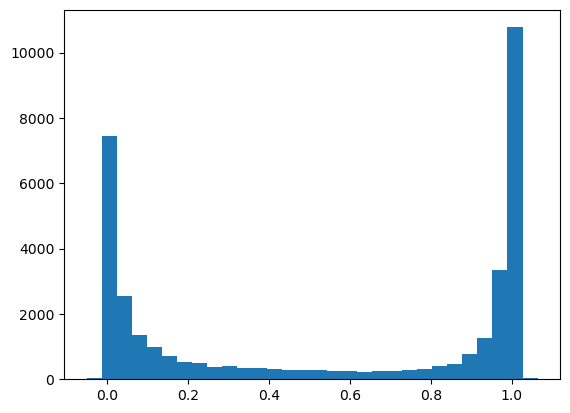

In [93]:
y_test3['Overall_Experience'].hist(bins = 30, grid = False)

In [94]:
y_test3.loc[y_test3['Overall_Experience']<.5,'Overall_Experience'] = 0
y_test3.loc[y_test3['Overall_Experience']>.5,'Overall_Experience'] = 1

<AxesSubplot: >

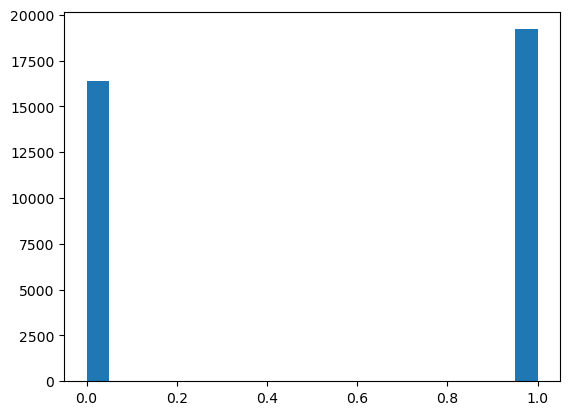

In [95]:
y_test3['Overall_Experience'].hist(bins = 20, grid = False)

In [96]:
y_test3.to_csv("BenjaminCooper_HackathonSubmission_V07.csv",index=False)

This method had prediction accuracy of 0.9508455, placing 23 in the Great Learning Hack Linguist Hackathon Competition

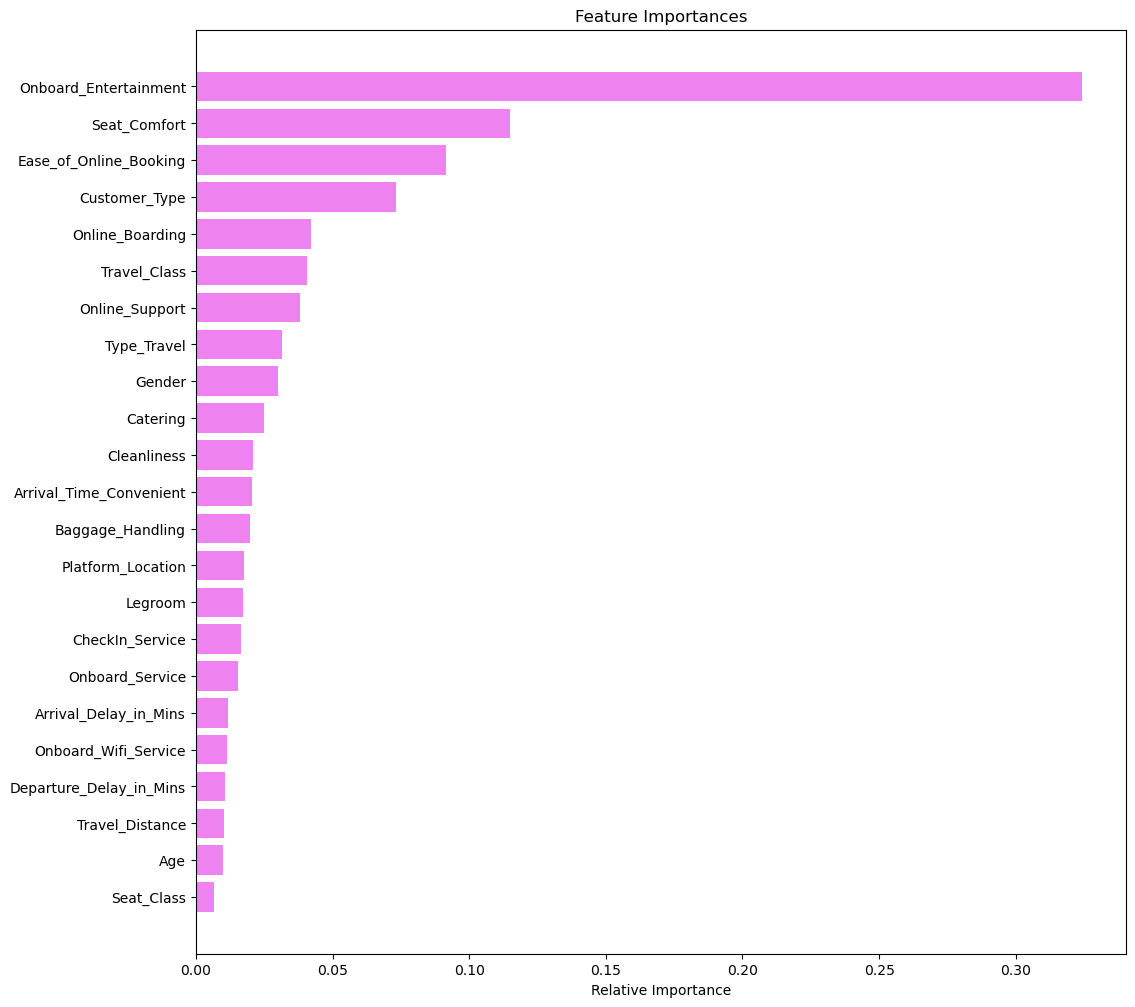

In [97]:
importances = xgb_tuned.feature_importances_

indices = np.argsort(importances)

feature_names = list(x_train2.columns)

plt.figure(figsize = (12, 12))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()